# 使用 VLM 监控的 SmolVLA 移除红块 Agent

本笔记展示如何结合 `SmolVLA` policy 与 GPT 系列的视觉语言模型（VLM），在 MuJoCo 仿真中以 Agent 形式自动执行“移除红块”任务，并根据 VLM 的反馈动态切换策略。


## 1. 环境与日志初始化

确保已经安装本仓库推荐的 conda 环境并成功运行过 `SmolVLA` 的部署示例。以下单元将设置日志级别，方便在 Notebook 中观察 Agent 的行为。


In [1]:
import logging

logging.basicConfig(level=logging.INFO, format="[%(asctime)s] %(levelname)s - %(message)s")
logging.getLogger("agent.remove_block_agent").setLevel(logging.INFO)
print("✅ 日志初始化完成")


✅ 日志初始化完成


In [2]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "asset").exists() and (PROJECT_ROOT / "Agent_empty_plat").exists():
    PROJECT_ROOT = (PROJECT_ROOT / "Agent_empty_plat").resolve()

if not (PROJECT_ROOT / "asset").exists():
    raise FileNotFoundError(f"无法定位项目根目录，请确认 Notebook 所在位置。当前 PROJECT_ROOT={PROJECT_ROOT}")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("✅ 已设置项目根目录:", PROJECT_ROOT)


✅ 已设置项目根目录: /home/dragon/Agent_empty_plat


## 2. 配置 VLM 客户端与策略仓库

- 这里示例使用 `so100` 机械臂，对应的 MuJoCo 场景为 `scene_remove_block_so100.xml`。
- `policy_repos` 用于注册不同相对位置的策略（可按需补充或替换）。
- VLM 默认处于 `dry_run` 模式，不会真实调用 GPT API。若要接入 OpenAI，请在外部配置 `OPENAI_API_KEY`，并将 `vlm_dry_run` 设为 `False`。


In [3]:
PROJECT_ROOT

PosixPath('/home/dragon/Agent_empty_plat')

In [4]:
from agent.remove_block_agent import (
    RemoveBlockAgentConfig,
    RemoveBlockAgent,
    GPTVLMClient,
)

policy_repos = {
    "center": "DragonHu/lerobot_remove_block_uniform_ramdom_smolvla_base",
    # 如需支持不同位置的策略，可在此添加：
    # "left": "<your-hf-repo-left>",
    # "right": "<your-hf-repo-right>",
    # "front": "<your-hf-repo-front>",
    # "back": "<your-hf-repo-back>",
}

SCENE_XML = "./asset/scene_remove_block_so100.xml"
DATASET_ROOT = "./demo_data_language"
DATASET_REPO = "remove_red_block_from_plate_so100_smolvla_mujoco"

SO100_ENV_KWARGS = {
    "action_type": "joint_angle",
    "state_type": "joint_angle",
    "random_block_position": True,
    "plate_flat_radius": 0.102,
    "sampling_method": "latin_hypercube",
    "block_spawn_margin": 0.005,
}

config = RemoveBlockAgentConfig(
    xml_scene_path=SCENE_XML,
    dataset_root=DATASET_ROOT,
    dataset_repo_id=DATASET_REPO,
    policy_repos=policy_repos,
    default_policy="center",
    robot_type="so100",
    env_kwargs=SO100_ENV_KWARGS,
    vlm_dry_run=True,  # 设置为 False 即可启用真实 GPT API
)
config.ensure()
print(config)


/home/dragon/anaconda3/envs/mujoco_vla/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2025-11-02 22:44:06,079] INFO - PyTorch version 2.7.1 available.


RemoveBlockAgentConfig(xml_scene_path='./asset/scene_remove_block_so100.xml', dataset_root='./demo_data_language', dataset_repo_id='remove_red_block_from_plate_so100_smolvla_mujoco', policy_repos={'center': 'DragonHu/lerobot_remove_block_uniform_ramdom_smolvla_base'}, default_policy='center', robot_type='so100', env_kwargs={'action_type': 'joint_angle', 'state_type': 'joint_angle', 'random_block_position': True, 'plate_flat_radius': 0.102, 'sampling_method': 'latin_hypercube', 'block_spawn_margin': 0.005}, device='cuda', image_size=256, sim_steps_per_action=8, max_steps_per_attempt=180, render=True, log_interval=20, save_debug_images=False, debug_dir='./media/remove_block_agent', seed=None, vlm_model='gpt-4.1-mini', vlm_base_url='https://api.openai.com/v1', vlm_dry_run=True)


In [5]:
vlm_client = GPTVLMClient(
    model_name=config.vlm_model,
    base_url=config.vlm_base_url,
    dry_run=config.vlm_dry_run,
)

agent = RemoveBlockAgent(config=config, vlm_client=vlm_client)
print("✅ Agent 初始化完成")


[2025-11-02 22:44:06,517] INFO - GPTVLMClient operating in dry-run mode (no API calls will be made).



-----------------------------------------------------------------------------
name:[Tabletop] dt:[0.002] HZ:[500]
 n_qpos:[27] n_qvel:[24] n_qacc:[24] n_ctrl:[6]
 integrator:[RK4]

n_body:[18]
 [0/18] [world] mass:[0.00]kg
 [1/18] [front_object_table] mass:[1.00]kg
 [2/18] [camera] mass:[0.00]kg
 [3/18] [camera2] mass:[0.00]kg
 [4/18] [camera3] mass:[0.00]kg
 [5/18] [Base] mass:[0.56]kg
 [6/18] [Rotation_Pitch] mass:[0.12]kg
 [7/18] [Upper_Arm] mass:[0.16]kg
 [8/18] [Lower_Arm] mass:[0.15]kg
 [9/18] [Wrist_Pitch_Roll] mass:[0.07]kg
 [10/18] [Fixed_Jaw] mass:[0.09]kg
 [11/18] [camera_center] mass:[0.00]kg
 [12/18] [Moving_Jaw] mass:[0.02]kg
 [13/18] [body_obj_plate_11] mass:[0.00]kg
 [14/18] [object_plate_11] mass:[0.10]kg
 [15/18] [body_obj_mug_6] mass:[0.00]kg
 [16/18] [object_mug_6] mass:[0.08]kg
 [17/18] [body_obj_block_red] mass:[0.30]kg
body_total_mass:[2.66]kg

n_geom:[101]
geom_names:['floor', 'front_object_table', None, None, None, None, None, None, None, None, None, None, Non

## 3. 自定义 Prompt（可选）

`RemoveBlockAgent` 内部已经准备好默认的 prompt 模板。如果需要更细粒度的控制，可以继承 `GPTVLMClient` 或直接覆写 `describe_scene` / `evaluate_outcome` 来注入自定义 prompt。下面的代码块给出一个简单示例：


In [6]:
class CustomVLMClient(GPTVLMClient):
    """示例：通过覆写方法定制 prompt 结构。"""

    def describe_scene(self, image_bytes: bytes, task_hint: str):
        # 可以在这里构造完全自定义的 prompt
        return super().describe_scene(image_bytes, task_hint)

    def evaluate_outcome(self, image_bytes: bytes, stage_hint: str):
        # 同理，这里也可以加入额外的 JSON 字段约束
        return super().evaluate_outcome(image_bytes, stage_hint)

# 如需启用自定义 prompt，只需用 CustomVLMClient 替换 GPTVLMClient 即可：
# vlm_client = CustomVLMClient(model_name=config.vlm_model, base_url=config.vlm_base_url, dry_run=config.vlm_dry_run)
# agent = RemoveBlockAgent(config=config, vlm_client=vlm_client)


## 4. 启动单轮 Agent

运行 `run_episode` 将：

1. 重置仿真并采样初始图像发送给 VLM，总结任务条件；
2. 根据 VLM 返回的 block 相对位置选择策略，并执行 SmolVLA policy；
3. 结束后再次上传图像给 VLM，由其判断成功与否，并给出失败原因；
4. 将每次尝试的详细信息记录在字典中返回。


In [7]:
summary = agent.run_episode(
    instruction="Remove the red block from the plate.",
    max_attempts=2,
)
print("任务成功:", summary["success"])


[2025-11-02 22:44:11,651] INFO - Starting attempt 1


ik_err:[0.0163] is higher than ik_err_th:[0.0100].
You may want to increase max_ik_tick:[1000]
随机red block位置: [0.249, -0.148, 0.850]


[2025-11-02 22:44:11,943] INFO - Loading SmolVLA policy from DragonHu/lerobot_remove_block_uniform_ramdom_smolvla_base


DONE INITIALIZATION
Reducing the number of VLM layers to 16 ...


[2025-11-02 22:44:27,561] INFO - Selected policy 'center' for attempt 1
[2025-11-02 22:44:29,276] INFO - Step 20/180 completed for current attempt.
[2025-11-02 22:44:30,810] INFO - Step 40/180 completed for current attempt.
[2025-11-02 22:44:32,344] INFO - Step 60/180 completed for current attempt.
[2025-11-02 22:44:33,865] INFO - Step 80/180 completed for current attempt.
[2025-11-02 22:44:35,416] INFO - Step 100/180 completed for current attempt.
[2025-11-02 22:44:36,950] INFO - Step 120/180 completed for current attempt.
[2025-11-02 22:44:38,483] INFO - Step 140/180 completed for current attempt.
[2025-11-02 22:44:40,034] INFO - Step 160/180 completed for current attempt.
[2025-11-02 22:44:41,552] INFO - Step 180/180 completed for current attempt.
[2025-11-02 22:44:41,669] INFO - Attempt 1 failed: dry-run
[2025-11-02 22:44:41,669] INFO - Starting attempt 2
[2025-11-02 22:44:41,927] INFO - Selected policy 'center' for attempt 2


ik_err:[0.0163] is higher than ik_err_th:[0.0100].
You may want to increase max_ik_tick:[1000]
随机red block位置: [0.299, -0.270, 0.850]
DONE INITIALIZATION


[2025-11-02 22:44:43,439] INFO - Step 20/180 completed for current attempt.
[2025-11-02 22:44:44,955] INFO - Step 40/180 completed for current attempt.
[2025-11-02 22:44:46,506] INFO - Step 60/180 completed for current attempt.
[2025-11-02 22:44:48,024] INFO - Step 80/180 completed for current attempt.
[2025-11-02 22:44:49,544] INFO - Step 100/180 completed for current attempt.
[2025-11-02 22:44:51,063] INFO - Step 120/180 completed for current attempt.
[2025-11-02 22:44:52,597] INFO - Step 140/180 completed for current attempt.
[2025-11-02 22:44:54,148] INFO - Step 160/180 completed for current attempt.
[2025-11-02 22:44:55,699] INFO - Step 180/180 completed for current attempt.
[2025-11-02 22:44:55,812] INFO - Attempt 2 failed: dry-run


任务成功: False


### 查看完整日志

使用 `json.dumps` 可以更直观地观察每次尝试的 VLM 反馈、策略选择与执行步数。


{
  "attempts": [
    {
      "policy": "center",
      "initial_scene": {
        "mock": true,
        "payload": {
          "model": "gpt-4.1-mini",
          "messages": [
            {
              "role": "system",
              "content": "You are a helpful robotics assistant that answers in JSON only."
            },
            {
              "role": "user",
              "content": [
                {
                  "type": "text",
                  "text": "You are assisting a robotic manipulation task. Analyse the provided image and\nsummarise the scene succinctly. Identify the red block relative to the plate\n(left/right/front/back/center) and optionally locate the banana if visible.\nThe high-level goal is: Remove the red block from the plate.\n\nRespond strictly in JSON with the fields:\n- task_summary: short natural language description\n- block_region: one of [left, right, front, back, center, unknown]\n- banana_region: optional string if a banana is visible (sam
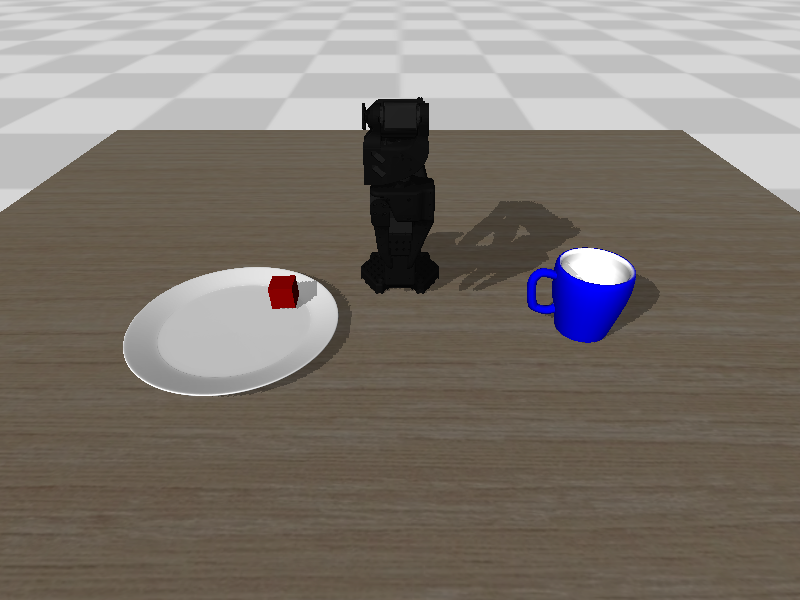
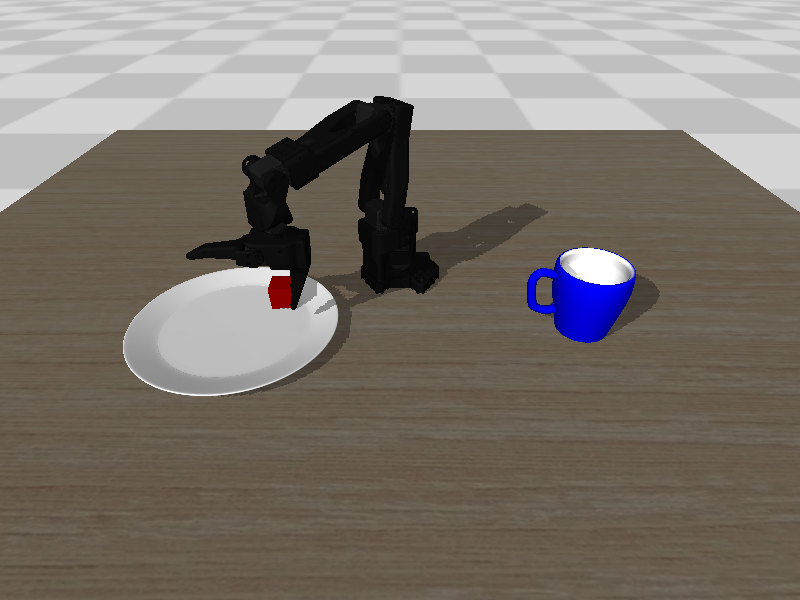
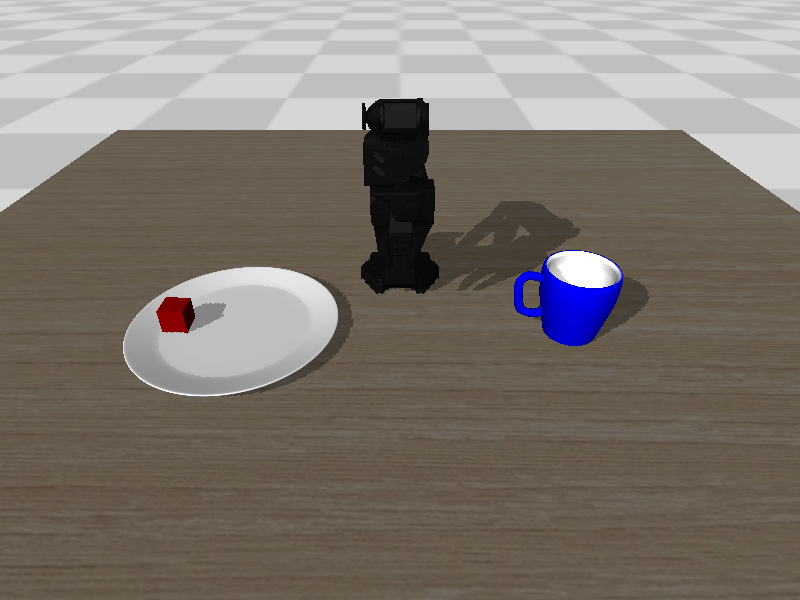
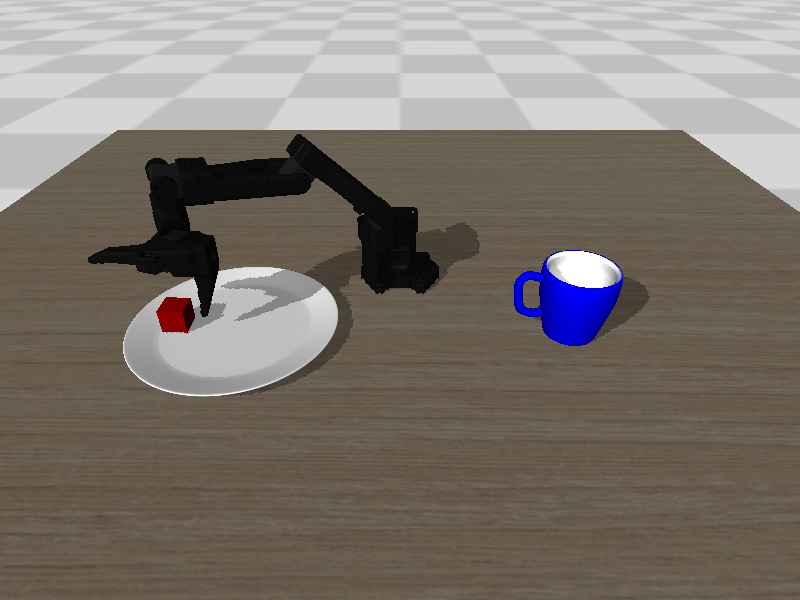
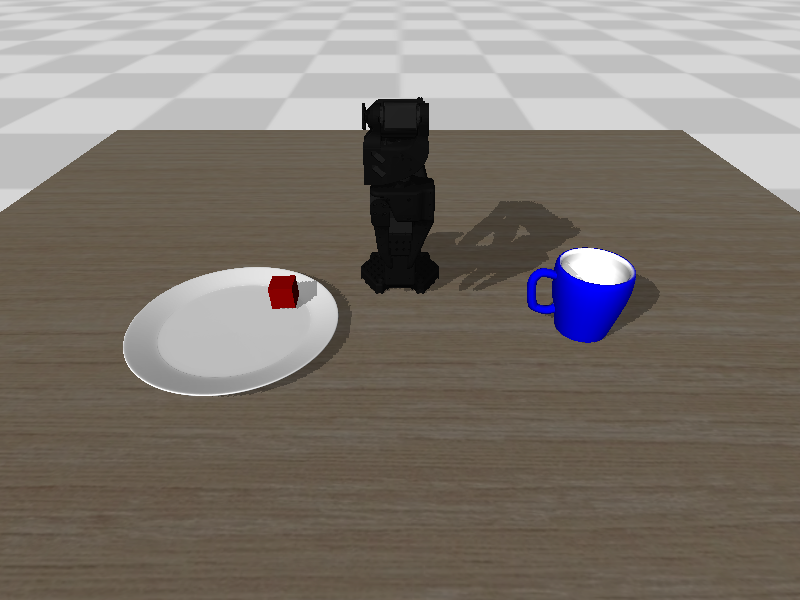

In [8]:
import json

print(json.dumps(summary, indent=2, ensure_ascii=False))


## 5. 后续可扩展方向

- **多策略扩展**：补充不同位置的 Hugging Face checkpoint，并在 `policy_repos` 中注册。
- **真实 VLM 接口**：设置 `OPENAI_API_KEY`，将 `vlm_dry_run=False`，即可通过 GPT 的多模态接口获取真实分析。
- **调试与可视化**：结合 `ipywidgets` 增加手动重试按钮，或在 `config.save_debug_images=True` 时自动保存关键帧。
- **终端控制**：`RemoveBlockAgent` 是纯 Python 类，可在脚本/终端中直接复用，实现批量评估或离线分析。
